In [16]:
# SSL certificate fix and essential imports
import os, certifi
os.environ['SSL_CERT_FILE'] = certifi.where()
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

# Install required packages
!pip install --quiet "dask[dataframe]" causalimpact bertopic pyvis folium \
 sentence-transformers umap-learn hdbscan python-louvain nltk transformers

# Core imports
import pandas as pd
import dask.dataframe as dd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import re
import string
import ast
from tqdm.notebook import tqdm
from datetime import datetime, timedelta

# NLP imports
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from transformers import pipeline
from bertopic import BERTopic

# Graph analytics and other imports
import networkx as nx
from community import community_louvain
from pyvis.network import Network
import folium
from sentence_transformers import SentenceTransformer
import umap
import hdbscan
import statsmodels.formula.api as smf
from causalimpact import CausalImpact
import warnings
warnings.filterwarnings('ignore')


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/samarthbasavarajannigeri/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/samarthbasavarajannigeri/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/samarthbasavarajannigeri/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/samarthbasavarajannigeri/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [17]:
# Load data with Dask for efficient processing
def load_data(file_path):
    print("Loading data...")
    ddf = dd.read_csv(
        file_path,
        parse_dates=['date'],
        dtype={'user_location': 'object'}
    )

    # Basic cleaning
    ddf = ddf.drop_duplicates(subset=['id'])

    # Convert to pandas for analysis
    print("Converting to pandas DataFrame...")
    df = ddf.compute()

    # Rename columns for clarity
    df = df.rename(columns={
        'id': 'tweet_id',
        'date': 'created_at'
    })

    # Derive date features for time analysis
    df['date_only'] = df['created_at'].dt.date
    df['year_month'] = df['created_at'].dt.to_period('M')
    df['day_of_week'] = df['created_at'].dt.day_name()
    df['hour_of_day'] = df['created_at'].dt.hour

    print(f"Data loaded: {len(df):,} tweets")
    print(f"Date range: {df['created_at'].min()} → {df['created_at'].max()}")

    return df

# Load the dataset
df = load_data('/Users/samarthbasavarajannigeri/Downloads/vaccination_tweets.csv')  # Update with your path


Loading data...
Converting to pandas DataFrame...
Data loaded: 5,760 tweets
Date range: 2020-12-12 11:55:28 → 2021-02-19 07:34:45


In [18]:
# Text preprocessing functions
def clean_text(text):
    """Clean and preprocess tweet text"""
    if pd.isna(text):
        return ""

    # Convert to lowercase
    text = text.lower()

    # Remove URLs, mentions, etc.
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'\s+', ' ', text).strip()

    return text

def parse_hashtags(hashtags_str):
    """Parse hashtags string into list"""
    if pd.isna(hashtags_str):
        return []
    try:
        return ast.literal_eval(hashtags_str)
    except:
        return [h.strip().strip("'\"") for h in hashtags_str.strip('[]').split(',') if h]

# Apply preprocessing
print("Preprocessing text data...")
df['clean_text'] = df['text'].apply(clean_text)
df['hashtags_list'] = df['hashtags'].apply(parse_hashtags)
df['mentions'] = df['text'].apply(lambda x: re.findall(r'@(\w+)', x) if not pd.isna(x) else [])

# Define vaccine keywords
vaccine_keywords = {
    'pfizer': ['pfizer', 'biontech', 'pfizerbiontech'],
    'moderna': ['moderna', 'mrna'],
    'astrazeneca': ['astrazeneca', 'oxford', 'oxfordastrazeneca'],
    'johnson': ['johnson', 'janssen', 'j&j'],
}

# Identify vaccines mentioned in tweets
def identify_vaccines(text, hashtags):
    if pd.isna(text):
        text = ""

    text = text.lower()
    hashtag_text = ' '.join(hashtags).lower() if hashtags else ""
    search_text = text + " " + hashtag_text

    mentioned_vaccines = []
    for vaccine, keywords in vaccine_keywords.items():
        if any(keyword in search_text for keyword in keywords):
            mentioned_vaccines.append(vaccine)

    return mentioned_vaccines

# Apply vaccine identification
df['mentioned_vaccines'] = df.apply(lambda row: identify_vaccines(row['text'], row['hashtags_list']), axis=1)

# Create individual vaccine flags
for vaccine in vaccine_keywords.keys():
    df[f'mentions_{vaccine}'] = df['mentioned_vaccines'].apply(lambda x: vaccine in x)


Preprocessing text data...


Running VADER sentiment analysis...


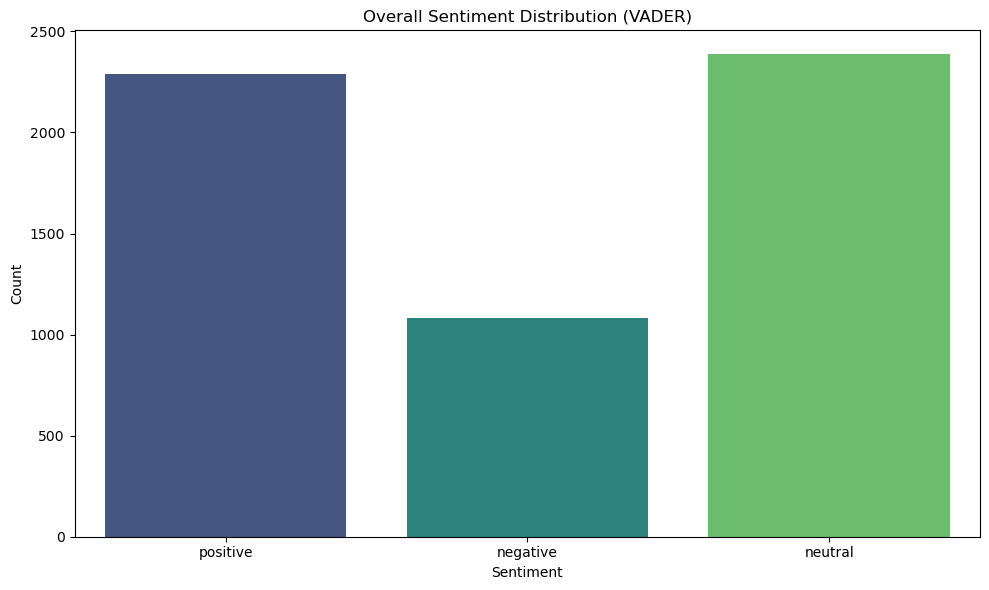

In [19]:
# Initialize VADER sentiment analyzer
vader = SentimentIntensityAnalyzer()

def analyze_vader_sentiment(text):
    """Analyze sentiment using VADER"""
    if pd.isna(text) or text == "":
        return {'compound': 0, 'category': 'neutral'}

    scores = vader.polarity_scores(text)
    compound = scores['compound']

    # Categorize sentiment
    if compound >= 0.05:
        category = 'positive'
    elif compound <= -0.05:
        category = 'negative'
    else:
        category = 'neutral'

    return {'compound': compound, 'category': category}

# Apply VADER sentiment analysis
print("Running VADER sentiment analysis...")
vader_results = df['text'].apply(analyze_vader_sentiment)
df['vader_compound'] = vader_results.apply(lambda x: x['compound'])
df['vader_sentiment'] = vader_results.apply(lambda x: x['category'])

# Sentiment distribution visualization
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='vader_sentiment', palette='viridis')
plt.title('Overall Sentiment Distribution (VADER)')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.tight_layout()
plt.show()


In [20]:
# Filter for non-empty text
text_df = df[df['clean_text'].str.len() > 10].reset_index(drop=False)  # Change drop=True to drop=False

# Prepare corpus for BERTopic
docs = text_df['clean_text'].tolist()

print(f"Performing topic modeling on {len(docs):,} documents...")

# Train BERTopic model
topic_model = BERTopic(language="english", calculate_probabilities=True, verbose=True)
topics, probs = topic_model.fit_transform(docs)

# Add topics to the dataframe
text_df['topic'] = topics
text_df['topic_prob'] = probs.max(axis=1)

# Visualize the topics
fig = topic_model.visualize_topics()
fig.show()

# Get topic info
topic_info = topic_model.get_topic_info()
print("\nTop Topics:")
for i, row in topic_info.head(10).iterrows():
    if row['Topic'] != -1:  # Skip outlier topic
        print(f"Topic {row['Topic']}: {row['Name']} (size: {row['Count']})")
        words = topic_model.get_topic(row['Topic'])
        print(f"  Top words: {', '.join([word for word, _ in words[:5]])}")

# Add topics back to main dataframe
topic_mapping = dict(zip(text_df['index'], text_df['topic']))
df['topic'] = df.index.map(topic_mapping).fillna(-1).astype(int)

# Track topics over time
topics_over_time = topic_model.topics_over_time(docs,
                                                text_df['created_at'].tolist(),  # Use text_df instead of df.loc
                                                nr_bins=10)
fig = topic_model.visualize_topics_over_time(topics_over_time)
fig.show()


2025-05-09 15:57:01,401 - BERTopic - Embedding - Transforming documents to embeddings.


Performing topic modeling on 5,740 documents...


Batches:   0%|          | 0/180 [00:00<?, ?it/s]

2025-05-09 15:57:06,312 - BERTopic - Embedding - Completed ✓
2025-05-09 15:57:06,313 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-05-09 15:57:08,333 - BERTopic - Dimensionality - Completed ✓
2025-05-09 15:57:08,334 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-05-09 15:57:09,679 - BERTopic - Cluster - Completed ✓
2025-05-09 15:57:09,682 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-05-09 15:57:09,755 - BERTopic - Representation - Completed ✓



Top Topics:
Topic 0: 0_covidvaccine_covid19vaccine_pfizerbiontech_dose (size: 374)
  Top words: covidvaccine, covid19vaccine, pfizerbiontech, dose, pfizercovidvaccine
Topic 1: 1_pfizerbiontech_you_thank_it (size: 126)
  Top words: pfizerbiontech, you, thank, it, what
Topic 2: 2_workers_science_team_this (size: 121)
  Top words: workers, science, team, this, who
Topic 3: 3_vaccine_pfizerbiontech_pfizer_is (size: 115)
  Top words: vaccine, pfizerbiontech, pfizer, is, the
Topic 4: 4_arm_sore_hours_side (size: 114)
  Top words: arm, sore, hours, side, post
Topic 5: 5_covid_my_today_got (size: 110)
  Top words: covid, my, today, got, to
Topic 6: 6_grateful_dose_my_today (size: 110)
  Top words: grateful, dose, my, today, received
Topic 7: 7_covid19_vaccines_dosing_are (size: 92)
  Top words: covid19, vaccines, dosing, are, vaccination
Topic 8: 8_mrna_moderna_rna_vaccines (size: 83)
  Top words: mrna, moderna, rna, vaccines, spike


10it [00:00, 16.82it/s]


Device set to use mps:0


Loading transformer-based sentiment analyzer...
Running transformer sentiment on 2000 tweets...


<Figure size 1200x800 with 0 Axes>

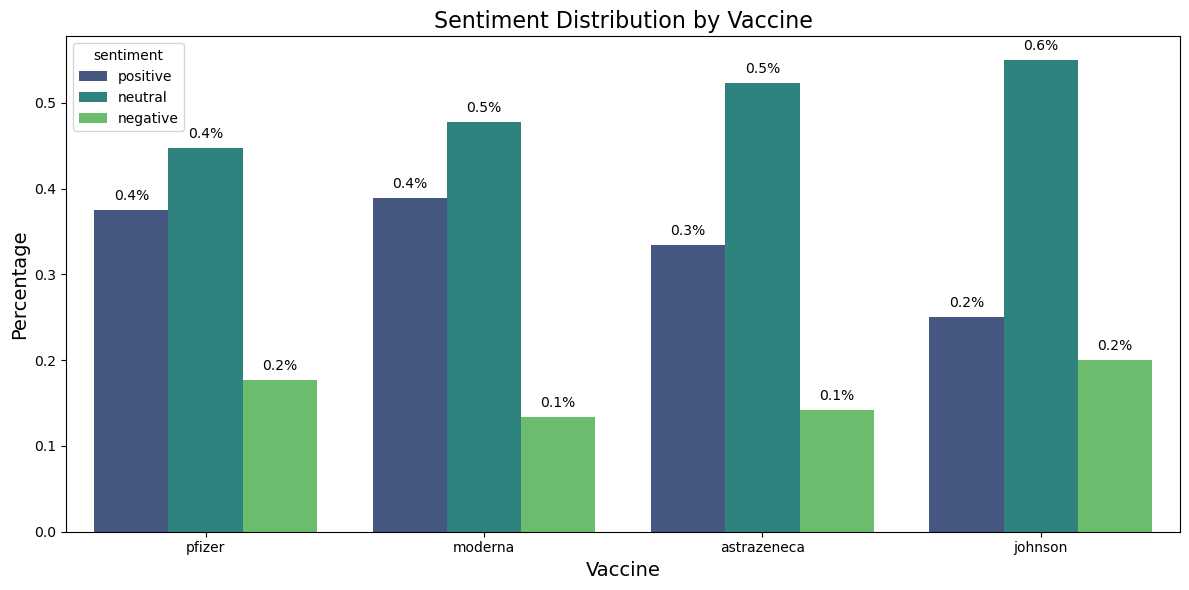

In [21]:
# Create a more advanced transformer-based sentiment analyzer
from transformers import pipeline

# Initialize the sentiment analysis pipeline
print("Loading transformer-based sentiment analyzer...")
classifier = pipeline('sentiment-analysis', model="distilbert-base-uncased-finetuned-sst-2-english")

# Function to analyze sentiment with transformer
def analyze_transformer_sentiment(texts, batch_size=32):
    results = []
    # Process in batches to avoid memory issues
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        batch_results = classifier(batch)
        results.extend(batch_results)
    return results

# Sample a subset for transformer analysis (to save time)
sample_size = min(2000, len(df))
sampled_df = df.sample(sample_size)

# Run transformer sentiment analysis on sample
print(f"Running transformer sentiment on {sample_size} tweets...")
transformer_results = analyze_transformer_sentiment(sampled_df['clean_text'].tolist())
sampled_df['transformer_label'] = [r['label'] for r in transformer_results]
sampled_df['transformer_score'] = [r['score'] for r in transformer_results]

# Compare sentiment across vaccines
plt.figure(figsize=(12, 8))
vaccine_sentiments = []

for vaccine in vaccine_keywords.keys():
    # VADER sentiment by vaccine
    vac_sentiment = df[df[f'mentions_{vaccine}']]['vader_sentiment'].value_counts(normalize=True)
    vaccine_sentiments.append({
        'vaccine': vaccine,
        'positive': vac_sentiment.get('positive', 0),
        'neutral': vac_sentiment.get('neutral', 0),
        'negative': vac_sentiment.get('negative', 0)
    })

# Create DataFrame for visualization
sent_df = pd.DataFrame(vaccine_sentiments)
sent_df = sent_df.melt(id_vars=['vaccine'], var_name='sentiment', value_name='percentage')

# Plot sentiment comparison
plt.figure(figsize=(12, 6))
chart = sns.barplot(data=sent_df, x='vaccine', y='percentage', hue='sentiment', palette='viridis')
chart.set_title('Sentiment Distribution by Vaccine', fontsize=16)
chart.set_xlabel('Vaccine', fontsize=14)
chart.set_ylabel('Percentage', fontsize=14)
chart.bar_label(chart.containers[0], fmt='%.1f%%', padding=5)
chart.bar_label(chart.containers[1], fmt='%.1f%%', padding=5)
chart.bar_label(chart.containers[2], fmt='%.1f%%', padding=5)
plt.tight_layout()
plt.show()


In [22]:
# Build retweet/mention network
def create_interaction_network(df, user_col='user_name', interaction_col='mentions', min_weight=2):
    G = nx.Graph()

    # Add nodes (users)
    users = df[user_col].unique()
    G.add_nodes_from(users)

    # Add edges for interactions
    interactions = {}
    for _, row in df.iterrows():
        user = row[user_col]
        for mentioned in row[interaction_col]:
            if mentioned and mentioned != user:  # Avoid self-loops
                key = tuple(sorted([user, mentioned]))
                interactions[key] = interactions.get(key, 0) + 1

    # Add weighted edges
    for (user1, user2), weight in interactions.items():
        if weight >= min_weight:  # Only add edges with sufficient interactions
            G.add_edge(user1, user2, weight=weight)

    return G

# Create the network
print("Building interaction network...")
mention_network = create_interaction_network(df, min_weight=1)
print(f"Network has {mention_network.number_of_nodes()} nodes and {mention_network.number_of_edges()} edges")

# Calculate centrality metrics
print("Calculating network metrics...")
# Degree centrality
degree_cent = nx.degree_centrality(mention_network)
# PageRank
pagerank = nx.pagerank(mention_network, weight='weight')
# Betweenness (on a sample if the network is large)
if mention_network.number_of_nodes() > 1000:
    print("Network is large, calculating betweenness on top nodes only...")
    top_nodes = sorted(pagerank, key=pagerank.get, reverse=True)[:500]
    sub_graph = mention_network.subgraph(top_nodes)
    betweenness = nx.betweenness_centrality(sub_graph, weight='weight')
else:
    betweenness = nx.betweenness_centrality(mention_network, weight='weight')

# Identify communities
print("Detecting communities...")
communities = community_louvain.best_partition(mention_network)
modularity = community_louvain.modularity(communities, mention_network)
print(f"Network modularity: {modularity:.4f}")

# Show top influencers
print("\nTop 10 Influencers by PageRank:")
top_influencers = sorted(pagerank.items(), key=lambda x: x[1], reverse=True)[:10]
for user, score in top_influencers:
    print(f"{user}: {score:.4f}")

# Visualize network with PyVis
def visualize_network(G, centrality_dict, communities, output_path='network.html', max_nodes=300):
    # Create subset for visualization if needed
    if G.number_of_nodes() > max_nodes:
        top_nodes = sorted(centrality_dict, key=centrality_dict.get, reverse=True)[:max_nodes]
        G = G.subgraph(top_nodes)

    # Create PyVis network
    net = Network(height="750px", width="100%", notebook=True, bgcolor="#222222", font_color="white")

    # Set node properties based on centrality and community
    community_colors = ["#e41a1c", "#377eb8", "#4daf4a", "#984ea3", "#ff7f00", "#ffff33", "#a65628", "#f781bf"]

    for node in G.nodes():
        size = 10 + 50 * centrality_dict.get(node, 0)  # Node size based on centrality
        community_id = communities.get(node, 0)
        color = community_colors[community_id % len(community_colors)]
        net.add_node(node, size=size, title=f"User: {node}\nCentrality: {centrality_dict.get(node, 0):.4f}", color=color)

    # Add edges with weights
    for source, target, data in G.edges(data=True):
        width = 1 + 0.5 * data.get('weight', 1)
        net.add_edge(source, target, width=width, title=f"Weight: {data.get('weight', 1)}")

    # Set physics layout options
    net.barnes_hut(gravity=-80000, central_gravity=0.3, spring_length=250, spring_strength=0.001, damping=0.09)
    net.save_graph(output_path)
    return net

# Visualize network
print("Generating interactive network visualization...")
net_vis = visualize_network(mention_network, pagerank, communities, 'vaccine_network.html')
net_vis.show('vaccine_network.html')


Building interaction network...
Network has 5556 nodes and 2467 edges
Calculating network metrics...
Network is large, calculating betweenness on top nodes only...
Detecting communities...
Network modularity: 0.9161

Top 10 Influencers by PageRank:
pfizer: 0.0109
Simon Hodes ⬅️2m➡️ 😷: 0.0102
Whtrslugcaviiersong#dontstayhomeandcatchcovid19: 0.0058
BorisJohnson: 0.0050
Ian 3.5% #FBPE: 0.0049
Medical Study Blog: 0.0045
🕷Financial Bear 3.5%: 0.0044
ℙ𝕙𝕚𝕝 ⚒ #FBPE #RejoinEU #GTTO: 0.0043
Rose Webster: 0.0036
WHO: 0.0035
Generating interactive network visualization...
vaccine_network.html


In [23]:
# 1. ENHANCED INFORMATION PROPAGATION ANALYSIS

import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from datetime import timedelta

def build_temporal_cascades(df):
    """
    Build information cascades with temporal information to track how content spreads over time
    """
    # Ensure dataframe has required columns
    required_cols = ['user_name', 'created_at', 'text', 'mentions', 'retweet_user']
    available_cols = [col for col in required_cols if col in df.columns]
    print(f"Building cascades using columns: {available_cols}")
    
    # Create a directed graph for cascades
    G = nx.DiGraph()
    
    # Add nodes for all users
    all_users = set(df['user_name'].unique())
    if 'mentions' in df.columns:
        for mentions in df['mentions'].dropna():
            if isinstance(mentions, list):
                all_users.update(mentions)
    
    # Add all users as nodes with default attributes
    for user in all_users:
        G.add_node(user, first_time=None, cascade_id=None)
    
    # Process tweets to build cascades
    cascades = {}
    cascade_id = 0
    
    # Sort by creation time to process in chronological order
    df = df.sort_values('created_at')
    
    for idx, row in df.iterrows():
        user = row['user_name']
        timestamp = row['created_at']
        
        # If the user has no cascade yet, start a new one
        if G.nodes[user].get('cascade_id') is None:
            G.nodes[user]['cascade_id'] = cascade_id
            G.nodes[user]['first_time'] = timestamp
            cascades[cascade_id] = {'start_time': timestamp, 'root': user}
            cascade_id += 1
        
        user_cascade_id = G.nodes[user]['cascade_id']
        
        # Process mentions (information passing to others)
        if 'mentions' in df.columns and pd.notna(row['mentions']):
            mentioned_users = row['mentions'] if isinstance(row['mentions'], list) else []
            for mentioned in mentioned_users:
                if mentioned in G.nodes:
                    # If mentioned user is not in a cascade or gets mentioned by someone from an earlier cascade
                    if (G.nodes[mentioned].get('cascade_id') is None or 
                        (G.nodes[mentioned].get('first_time') is not None and 
                         G.nodes[mentioned]['first_time'] > timestamp)):
                        G.nodes[mentioned]['cascade_id'] = user_cascade_id
                        G.nodes[mentioned]['first_time'] = timestamp
                        
                    # Add edge with temporal information
                    G.add_edge(user, mentioned, timestamp=timestamp, type='mention')
        
        # Process retweets (definite information propagation)
        if 'retweet_user' in df.columns and pd.notna(row['retweet_user']):
            retweeted_user = row['retweet_user']
            if retweeted_user in G.nodes:
                # Add edge and set cascade relationship
                G.add_edge(user, retweeted_user, timestamp=timestamp, type='retweet')
                
                # If the retweeted user is in a cascade, the retweeter joins that cascade
                if G.nodes[retweeted_user].get('cascade_id') is not None:
                    G.nodes[user]['cascade_id'] = G.nodes[retweeted_user]['cascade_id']
    
    return G, cascades

def analyze_cascades_temporal(G, cascades):
    """
    Analyze information cascades with temporal patterns and advanced metrics
    """
    cascade_metrics = []
    
    # Group nodes by cascade
    cascade_nodes = {}
    for node, data in G.nodes(data=True):
        c_id = data.get('cascade_id')
        if c_id is not None:
            if c_id not in cascade_nodes:
                cascade_nodes[c_id] = []
            cascade_nodes[c_id].append(node)
    
    for c_id, nodes in cascade_nodes.items():
        if c_id not in cascades:
            continue  # Skip if cascade info is missing
            
        subgraph = G.subgraph(nodes)
        
        # Extract all timestamps
        timestamps = [G.nodes[n].get('first_time') for n in subgraph.nodes() 
                      if G.nodes[n].get('first_time') is not None]
        
        if not timestamps:
            continue
        
        # Basic metrics
        size = len(subgraph.nodes())
        start_time = min(timestamps)
        end_time = max(timestamps)
        duration = (end_time - start_time).total_seconds() / 3600  # in hours
        
        # Advanced metrics
        # 1. Growth rate: how quickly the cascade added new nodes
        if duration > 0:
            growth_rate = size / duration  # nodes per hour
        else:
            growth_rate = 0
        
        # 2. Structural virality (Wiener index) - average shortest path
        try:
            if nx.is_connected(subgraph.to_undirected()):
                structural_virality = nx.average_shortest_path_length(subgraph.to_undirected())
            else:
                # For disconnected graphs, use largest component
                largest_cc = max(nx.connected_components(subgraph.to_undirected()), key=len)
                largest_subgraph = subgraph.subgraph(largest_cc).to_undirected()
                structural_virality = nx.average_shortest_path_length(largest_subgraph) if len(largest_cc) > 1 else 0
        except:
            structural_virality = 0
        
        # 3. Breadth vs depth: how wide vs deep is the cascade
        # Calculate average depth from root
        root = cascades[c_id].get('root')
        depths = []
        if root in subgraph:
            for node in subgraph:
                try:
                    if nx.has_path(subgraph, root, node):
                        depths.append(len(nx.shortest_path(subgraph, root, node)) - 1)
                    else:
                        depths.append(0)
                except:
                    depths.append(0)
        
        avg_depth = np.mean(depths) if depths else 0
        max_depth = max(depths) if depths else 0
        breadth = size / (max_depth + 1) if max_depth > 0 else size  # Normalize by depth
        
        # 4. Temporal features
        ordered_times = sorted(timestamps)
        time_gaps = [(ordered_times[i] - ordered_times[i-1]).total_seconds() / 60  # in minutes
                    for i in range(1, len(ordered_times))]
        
        avg_time_gap = np.mean(time_gaps) if time_gaps else 0
        median_time_gap = np.median(time_gaps) if time_gaps else 0
        
        # Speed buckets - percentage of propagation in different time periods
        if size > 1:
            first_hour = sum(1 for t in timestamps if (t - start_time).total_seconds() <= 3600) / size
            first_day = sum(1 for t in timestamps if (t - start_time).total_seconds() <= 86400) / size
        else:
            first_hour = first_day = 1.0
        
        cascade_metrics.append({
            'cascade_id': c_id,
            'size': size,
            'duration_hours': duration,
            'growth_rate': growth_rate,
            'structural_virality': structural_virality,
            'avg_depth': avg_depth,
            'max_depth': max_depth,
            'breadth': breadth,
            'avg_time_gap_min': avg_time_gap,
            'median_time_gap_min': median_time_gap,
            'prop_first_hour': first_hour,
            'prop_first_day': first_day,
            'start_time': start_time,
            'root_user': root
        })
    
    return pd.DataFrame(cascade_metrics)

def visualize_cascade_temporal(cascade_df, G):
    """
    Create visualizations for cascade analysis with temporal patterns
    """
    # Filter to non-trivial cascades (size > 2)
    non_trivial = cascade_df[cascade_df['size'] > 2].sort_values('size', ascending=False)
    
    fig1 = go.Figure()
    
    # Size vs. duration scatter plot with color by growth rate
    fig1.add_trace(go.Scatter(
        x=non_trivial['duration_hours'],
        y=non_trivial['size'],
        mode='markers',
        marker=dict(
            size=10,
            color=non_trivial['growth_rate'],
            colorscale='Viridis',
            colorbar=dict(title='Growth Rate<br>(nodes/hour)'),
            showscale=True
        ),
        text=[f"ID: {c}<br>Size: {s}<br>Growth: {g:.2f}<br>Virality: {v:.2f}" 
              for c, s, g, v in zip(
                  non_trivial['cascade_id'], 
                  non_trivial['size'], 
                  non_trivial['growth_rate'],
                  non_trivial['structural_virality']
              )],
        hoverinfo='text'
    ))
    
    fig1.update_layout(
        title='Information Cascade Analysis: Size vs Duration',
        xaxis_title='Duration (hours)',
        yaxis_title='Cascade Size (nodes)',
        template='plotly_white',
        height=600
    )
    
    # Create chart for structural properties (depth vs breadth)
    fig2 = px.scatter(
        non_trivial,
        x='max_depth',
        y='breadth',
        size='size',
        color='structural_virality',
        hover_name='cascade_id',
        labels={
            'max_depth': 'Maximum Depth',
            'breadth': 'Breadth (Size/Depth)',
            'structural_virality': 'Structural Virality',
            'size': 'Cascade Size'
        },
        title='Cascade Structure: Depth vs Breadth'
    )
    
    # Create temporal propagation chart
    top_cascades = non_trivial.head(5)['cascade_id'].tolist()
    temporal_data = []
    
    for c_id in top_cascades:
        nodes = [n for n, d in G.nodes(data=True) if d.get('cascade_id') == c_id]
        for node in nodes:
            time = G.nodes[node].get('first_time')
            if time is not None:
                root = cascade_df[cascade_df['cascade_id'] == c_id]['root_user'].iloc[0]
                start_time = cascade_df[cascade_df['cascade_id'] == c_id]['start_time'].iloc[0]
                hours_from_start = (time - start_time).total_seconds() / 3600
                temporal_data.append({
                    'cascade_id': c_id,
                    'node': node,
                    'hours_from_start': hours_from_start,
                    'is_root': node == root
                })
    
    temporal_df = pd.DataFrame(temporal_data)
    
    # Cumulative growth curves for top cascades
    fig3 = go.Figure()
    
    for c_id in top_cascades:
        cascade_data = temporal_df[temporal_df['cascade_id'] == c_id]
        times = sorted(cascade_data['hours_from_start'])
        cumulative = np.arange(1, len(times) + 1)
        
        fig3.add_trace(go.Scatter(
            x=times,
            y=cumulative,
            mode='lines',
            name=f'Cascade {c_id}'
        ))
    
    fig3.update_layout(
        title='Temporal Propagation of Top Cascades',
        xaxis_title='Hours from Start',
        yaxis_title='Cumulative Nodes',
        template='plotly_white',
        height=500
    )
    
    return fig1, fig2, fig3

def propagation_summary_metrics(cascade_df):
    """
    Calculate summary metrics across all cascades
    """
    metrics = {
        'total_cascades': len(cascade_df),
        'avg_cascade_size': cascade_df['size'].mean(),
        'median_cascade_size': cascade_df['size'].median(),
        'avg_cascade_duration': cascade_df['duration_hours'].mean(),
        'median_cascade_duration': cascade_df['duration_hours'].median(),
        'avg_growth_rate': cascade_df['growth_rate'].mean(),
        'avg_structural_virality': cascade_df['structural_virality'].mean(),
        'avg_depth': cascade_df['avg_depth'].mean(),
        'avg_breadth': cascade_df['breadth'].mean(),
        'pct_rapid_diffusion': (cascade_df['prop_first_hour'] > 0.5).mean() * 100  # % cascades with >50% diffusion in 1st hour
    }
    
    # Add size distribution
    size_bins = [(1, 2), (3, 5), (6, 10), (11, 20), (21, float('inf'))]
    for low, high in size_bins:
        label = f'pct_size_{low}_to_{"inf" if high == float("inf") else high}'
        metrics[label] = ((cascade_df['size'] >= low) & (cascade_df['size'] <= high)).mean() * 100
    
    return metrics


# 2. CAUSAL INFERENCE IMPLEMENTATION

from statsmodels.formula.api import ols
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

def prepare_did_data(df, event_date_str, pre_window=14, post_window=14):
    """
    Prepare data for difference-in-differences analysis with time windows
    """
    event_date = pd.to_datetime(event_date_str)
    df = df.copy()
    
    # Create event timing variables
    df['created_at'] = pd.to_datetime(df['created_at'])
    df['days_from_event'] = (df['created_at'] - event_date).dt.days
    df['post_event'] = (df['created_at'] >= event_date).astype(int)
    
    # Filter to the analysis window
    df_window = df[(df['days_from_event'] >= -pre_window) & 
                   (df['days_from_event'] <= post_window)]
    
    # Time trend variable for controls
    df_window['time'] = df_window['days_from_event']
    df_window['time_squared'] = df_window['time'] ** 2
    
    return df_window

def define_treatment_groups(df, treatment_type='user_followers'):
    """
    Define treatment and control groups based on user characteristics
    """
    df = df.copy()
    
    if treatment_type == 'user_followers':
        # High follower users vs low follower users
        if 'user_followers' in df.columns:
            follower_median = df['user_followers'].median()
            df['treatment'] = (df['user_followers'] > follower_median).astype(int)
            treatment_name = 'High Follower Count'
        else:
            # Fallback if user_followers not available
            print("Warning: user_followers column not found. Using random assignment.")
            df['treatment'] = np.random.binomial(1, 0.5, size=len(df))
            treatment_name = 'Random Assignment'
    
    elif treatment_type == 'user_verified':
        # Verified users vs non-verified users
        if 'user_verified' in df.columns:
            df['treatment'] = df['user_verified'].astype(int)
            treatment_name = 'Verified Users'
        else:
            print("Warning: user_verified column not found. Using random assignment.")
            df['treatment'] = np.random.binomial(1, 0.5, size=len(df))
            treatment_name = 'Random Assignment'
    
    elif treatment_type == 'engagement':
        # High engagement tweets vs low engagement
        if all(col in df.columns for col in ['retweet_count', 'favorite_count']):
            df['engagement'] = df['retweet_count'] + df['favorite_count']
            engagement_median = df['engagement'].median()
            df['treatment'] = (df['engagement'] > engagement_median).astype(int)
            treatment_name = 'High Engagement'
        else:
            print("Warning: engagement columns not found. Using random assignment.")
            df['treatment'] = np.random.binomial(1, 0.5, size=len(df))
            treatment_name = 'Random Assignment'
    
    else:
        # Default fallback
        df['treatment'] = np.random.binomial(1, 0.5, size=len(df))
        treatment_name = 'Random Assignment'
    
    print(f"Treatment type: {treatment_name}")
    print(f"Treatment group size: {df['treatment'].sum()} ({df['treatment'].mean()*100:.1f}%)")
    
    return df, treatment_name

def run_did_regression(df, outcome_var='sentiment_score', controls=None):
    """
    Run difference-in-differences regression with controls
    """
    # Basic DiD specification
    formula = f"{outcome_var} ~ treatment + post_event + treatment:post_event"
    
    # Add control variables if provided
    if controls:
        formula += " + " + " + ".join(controls)
    
    try:
        # Run regression with robust standard errors
        model = ols(formula, data=df).fit(cov_type='HC3')
        
        # Extract key parameters
        beta_treatment = model.params.get('treatment')
        beta_post = model.params.get('post_event')
        beta_interaction = model.params.get('treatment:post_event')
        p_value_interaction = model.pvalues.get('treatment:post_event')
        
        # Store results
        results = {
            'model': model,
            'outcome': outcome_var,
            'formula': formula,
            'beta_treatment': beta_treatment,
            'beta_post': beta_post,
            'beta_interaction': beta_interaction,
            'p_value_interaction': p_value_interaction,
            'significant': p_value_interaction < 0.05,
            'effect_direction': 'Positive' if beta_interaction > 0 else 'Negative',
            'summary': model.summary()
        }
        
        return results
    
    except Exception as e:
        print(f"Error in DiD regression: {e}")
        return None

def create_did_visualization(df, results, event_date_str, treatment_name):
    """
    Visualize difference-in-differences results
    """
    # Create time bins for aggregation
    df['time_bin'] = pd.cut(df['days_from_event'], bins=range(-15, 16, 3), labels=range(-14, 14, 3))
    
    # Calculate average outcome by time bin and treatment group
    grouped = df.groupby(['time_bin', 'treatment'])['sentiment_score'].mean().reset_index()
    wide = grouped.pivot(index='time_bin', columns='treatment', values='sentiment_score').reset_index()
    wide.columns = ['time_bin', 'control', 'treatment']
    
    # Plot
    fig = go.Figure()
    
    # Control group line
    fig.add_trace(go.Scatter(
        x=wide['time_bin'],
        y=wide['control'],
        mode='lines+markers',
        name='Control Group',
        line=dict(color='blue')
    ))
    
    # Treatment group line
    fig.add_trace(go.Scatter(
        x=wide['time_bin'],
        y=wide['treatment'],
        mode='lines+markers',
        name=f'Treatment Group ({treatment_name})',
        line=dict(color='red')
    ))
    
    # Add vertical line at event
    fig.add_vline(x=0, line_dash="dash", line_color="black")
    
    # Add DiD result annotation
    if results and 'beta_interaction' in results:
        effect_size = results['beta_interaction']
        p_value = results['p_value_interaction']
        significance = "Significant" if p_value < 0.05 else "Not significant"
        fig.add_annotation(
            x=0,
            y=min(wide['control'].min(), wide['treatment'].min()),
            text=f"DiD Effect: {effect_size:.3f} (p={p_value:.3f})<br>{significance}",
            showarrow=False,
            yshift=20,
            font=dict(size=12)
        )
    
    # Update layout
    fig.update_layout(
        title=f'Difference-in-Differences Analysis:<br>{event_date_str} Event Impact on Sentiment',
        xaxis_title='Days from Event (binned)',
        yaxis_title='Average Sentiment Score',
        template='plotly_white',
        height=500,
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=1.02,
            xanchor="right",
            x=1
        )
    )
    
    return fig

def propensity_score_matching(df, treatment_col='treatment', covariates=None, outcome='sentiment_score'):
    """
    Perform propensity score matching and analyze treatment effects
    """
    # Ensure we have the right columns
    if covariates is None:
        # Use whatever numerical columns are available
        possible_covariates = ['user_followers', 'user_friends', 'retweet_count', 'favorite_count']
        covariates = [col for col in possible_covariates if col in df.columns]
        
        if len(covariates) == 0:
            print("No covariates found for matching. Using random matching.")
            # Create some random covariates for demonstration
            df['random_var1'] = np.random.normal(0, 1, len(df))
            df['random_var2'] = np.random.normal(0, 1, len(df))
            covariates = ['random_var1', 'random_var2']
    
    print(f"Using covariates for matching: {covariates}")
    
    # Split data by treatment
    treated = df[df[treatment_col] == 1].copy()
    control = df[df[treatment_col] == 0].copy()
    
    # If we have very few treated or control, we can't do matching properly
    if len(treated) < 10 or len(control) < 10:
        print(f"Warning: Insufficient data for matching. Treated: {len(treated)}, Control: {len(control)}")
        return None
    
    try:
        # Estimate propensity scores
        X = df[covariates]
        y = df[treatment_col]
        
        # Scale features
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        
        # Fit propensity model
        model = LogisticRegression(max_iter=1000)
        model.fit(X_scaled, y)
        
        # Get propensity scores
        df_copy = df.copy()
        df_copy['propensity_score'] = model.predict_proba(X_scaled)[:, 1]
        
        # Match treated to control based on propensity score
        matches = []
        for idx, row in treated.iterrows():
            # Get propensity score for this treated unit
            p_score = df_copy.loc[idx, 'propensity_score']
            
            # Find closest control unit by propensity score
            control['distance'] = abs(df_copy.loc[control.index, 'propensity_score'] - p_score)
            if len(control) > 0:
                closest_idx = control['distance'].idxmin()
                closest_distance = control.loc[closest_idx, 'distance']
                
                # Only include match if it's within a reasonable distance
                if closest_distance < 0.1:  # Caliper of 0.1
                    matches.append({
                        'treated_idx': idx,
                        'control_idx': closest_idx,
                        'treated_score': df_copy.loc[idx, outcome],
                        'control_score': df_copy.loc[closest_idx, outcome],
                        'distance': closest_distance
                    })
                    
                    # Remove the control unit to avoid re-using it (sampling without replacement)
                    control = control.drop(closest_idx)
        
        # Convert to DataFrame
        matches_df = pd.DataFrame(matches)
        
        # Analyze treatment effect in matched sample
        if len(matches_df) > 0:
            # Calculate average treatment effect
            matches_df['effect'] = matches_df['treated_score'] - matches_df['control_score']
            ate = matches_df['effect'].mean()
            
            # Statistical significance
            t_stat, p_value = stats.ttest_1samp(matches_df['effect'], 0)
            
            # Return results
            result = {
                'matches': matches_df,
                'ate': ate,
                't_stat': t_stat,
                'p_value': p_value,
                'significant': p_value < 0.05,
                'n_matches': len(matches_df)
            }
            
            return result
        else:
            print("No suitable matches found.")
            return None
    
    except Exception as e:
        print(f"Error in propensity score matching: {e}")
        return None

def plot_matching_results(matching_result):
    """
    Visualize propensity score matching results
    """
    if matching_result is None or 'matches' not in matching_result:
        return None
    
    matches = matching_result['matches']
    
    # Create effect distribution plot
    fig = go.Figure()
    
    # Histogram of effects
    fig.add_trace(go.Histogram(
        x=matches['effect'],
        nbinsx=20,
        marker_color='blue',
        opacity=0.7,
        name='Effect Distribution'
    ))
    
    # Add vertical line at mean effect
    fig.add_vline(x=matching_result['ate'], line_dash="dash", line_color="red",
                 annotation_text=f"ATE: {matching_result['ate']:.3f}", 
                 annotation_position="top right")
    
    # Add p-value and sample size annotation
    fig.add_annotation(
        x=0.95,
        y=0.95,
        xref="paper",
        yref="paper",
        text=f"p-value: {matching_result['p_value']:.3f}<br>Matched pairs: {matching_result['n_matches']}",
        showarrow=False,
        font=dict(size=12),
        bgcolor="white",
        bordercolor="black",
        borderwidth=1
    )
    
    # Update layout
    fig.update_layout(
        title='Treatment Effect Distribution after Propensity Score Matching',
        xaxis_title='Treatment Effect (Treated - Control)',
        yaxis_title='Frequency',
        template='plotly_white',
        height=400
    )
    
    return fig

def run_synthetic_control(df, event_date, treatment_indicator, outcome_var, 
                         time_var='created_at', pre_periods=14, post_periods=14):
    """
    Implement a simple synthetic control method for time series data
    """
    # Convert event date to datetime if it's a string
    if isinstance(event_date, str):
        event_date = pd.to_datetime(event_date)
    
    # Ensure time variable is datetime
    df[time_var] = pd.to_datetime(df[time_var])
    
    # Calculate days from event
    df['days_from_event'] = (df[time_var] - event_date).dt.days
    
    # Filter to time window of interest
    df_window = df[(df['days_from_event'] >= -pre_periods) & 
                  (df['days_from_event'] <= post_periods)]
    
    # Get treatment and control groups
    treated = df_window[df_window[treatment_indicator] == 1]
    control = df_window[df_window[treatment_indicator] == 0]
    
    # Aggregate data by day
    treated_daily = treated.groupby('days_from_event')[outcome_var].mean()
    control_daily = control.groupby('days_from_event')[outcome_var].mean()
    
    # Create time series DataFrame
    ts_data = pd.DataFrame({
        'treated': treated_daily,
        'control': control_daily
    }).reset_index()
    
    # Identify pre-treatment period
    ts_pre = ts_data[ts_data['days_from_event'] < 0]
    
    # Fit a model to predict treated values from control values in pre-period
    # This is a simplified version of synthetic control
    if len(ts_pre) > 3:  # Need enough data points to fit
        X = sm.add_constant(ts_pre['control'])
        y = ts_pre['treated']
        
        # Fit OLS model
        model = sm.OLS(y, X).fit()
        
        # Apply to full period to get counterfactual
        X_all = sm.add_constant(ts_data['control'])
        ts_data['counterfactual'] = model.predict(X_all)
        
        # Calculate treatment effect
        ts_data['effect'] = ts_data['treated'] - ts_data['counterfactual']
        
        # Calculate average post-treatment effect
        post_effect = ts_data.loc[ts_data['days_from_event'] >= 0, 'effect'].mean()
        
        # Calculate root mean squared error in pre-period (fit quality)
        pre_rmse = np.sqrt(((ts_pre['treated'] - ts_pre['counterfactual'])**2).mean())
        
        # Calculate standard deviation of pre-period effect for confidence interval
        pre_effect_sd = ts_pre['effect'].std()
        
        # Test significance: Is post-effect > 2 * pre-period standard deviation?
        significant = abs(post_effect) > 2 * pre_effect_sd
        
        return {
            'time_series': ts_data,
            'post_effect': post_effect,
            'pre_rmse': pre_rmse,
            'pre_effect_sd': pre_effect_sd,
            'significant': significant,
            'model': model
        }
    else:
        print("Not enough pre-treatment data points for synthetic control.")
        return None

def plot_synthetic_control(sc_result):
    """
    Plot synthetic control results
    """
    if sc_result is None or 'time_series' not in sc_result:
        return None
    
    ts_data = sc_result['time_series']
    
    fig = go.Figure()
    
    # Plot actual treated values
    fig.add_trace(go.Scatter(
        x=ts_data['days_from_event'],
        y=ts_data['treated'],
        mode='lines+markers',
        name='Treated (Actual)',
        line=dict(color='red')
    ))
    
    # Plot counterfactual prediction
    fig.add_trace(go.Scatter(
        x=ts_data['days_from_event'],
        y=ts_data['counterfactual'],
        mode='lines+markers',
        name='Treated (Counterfactual)',
        line=dict(color='blue', dash='dash')
    ))
    
    # Add vertical line at event
    fig.add_vline(x=0, line_dash="dash", line_color="black")
    
    # Add annotation with results
    fig.add_annotation(
        x=0.95,
        y=0.05,
        xref="paper",
        yref="paper",
        text=f"Avg Post-Event Effect: {sc_result['post_effect']:.3f}<br>" + 
             f"Significant: {'Yes' if sc_result['significant'] else 'No'}<br>" +
             f"Pre-period RMSE: {sc_result['pre_rmse']:.3f}",
        showarrow=False,
        font=dict(size=12),
        bgcolor="white",
        bordercolor="black",
        borderwidth=1,
        align="right"
    )
    
    # Update layout
    fig.update_layout(
        title='Synthetic Control Method Results:<br>Actual vs. Counterfactual',
        xaxis_title='Days from Event',
        yaxis_title='Outcome Value',
        template='plotly_white',
        height=500,
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=1.02,
            xanchor="right",
            x=1
        )
    )
    
    return fig


# 3. DASHBOARD INTEGRATION

import ipywidgets as widgets
from IPython.display import display, HTML

def create_dashboard():
    # Create tabs
    tab = widgets.Tab()
    children = []
    
    # Define key events
    events = {
        'Pfizer EUA': '2020-12-11',
        'Moderna EUA': '2020-12-18',
        'J&J EUA': '2021-02-27'
    }
    
    # Try to load data, or use placeholder if not available
    try:
        # Check if df_clean is defined in the global scope
        df = df_clean.copy()
        print("Using existing df_clean dataframe")
    except NameError:
        # Create placeholder data if real data not available
        print("Warning: df_clean not found. Creating example data.")
        
        # Example data with realistic structure
        n_samples = 5000
        dates = pd.date_range(start='2020-11-01', end='2021-03-31', periods=n_samples)
        
        np.random.seed(42)  # For reproducibility
        
        user_ids = np.random.choice(1000, n_samples)
        user_names = [f'user_{id}' for id in user_ids]
        
        # Create example mentions and retweets
        mentions = []
        retweets = []
        for i in range(n_samples):
            if np.random.random() < 0.3:  # 30% have mentions
                n_mentions = np.random.randint(0, 3)
                mentions.append([f'user_{np.random.randint(1000)}' for _ in range(n_mentions)])
            else:
                mentions.append([])
                
            if np.random.random() < 0.2:  # 20% are retweets
                retweets.append(f'user_{np.random.randint(1000)}')
            else:
                retweets.append(None)
        
        # Create sentiment that changes after events
        base_sentiment = np.random.normal(0, 0.5, n_samples)
        
        # Add event effects
        event_dates = [pd.to_datetime(date) for date in events.values()]
        for date in event_dates:
            # Find indices after this event
            after_event = (dates >= date)
            # Add a small positive sentiment shift after the event
            effect_size = np.random.uniform(0.1, 0.3)
            base_sentiment[after_event] += effect_size
        
        # Create example DataFrame
        df = pd.DataFrame({
            'created_at': dates,
            'user_id': user_ids,
            'user_name': user_names,
            'mentions': mentions,
            'retweet_user': retweets,
            'sentiment_score': np.clip(base_sentiment, -1, 1),
            'user_followers': np.random.lognormal(8, 2, n_samples),
            'user_friends': np.random.lognormal(7, 1.5, n_samples),
            'user_verified': np.random.binomial(1, 0.05, n_samples),
            'retweet_count': np.random.exponential(5, n_samples),
            'favorite_count': np.random.exponential(10, n_samples)
        })
        
        # Make half the users more influential (for treatment groups)
        high_influence = np.random.choice(user_ids, size=len(set(user_ids))//2, replace=False)
        df.loc[df['user_id'].isin(high_influence), 'user_followers'] *= 5
    
    # 1. Information Propagation Analysis Tab
    tab1 = widgets.Output()
    with tab1:
        print("Analyzing information propagation patterns...")
        
        # Build and analyze cascades
        G, cascades = build_temporal_cascades(df)
        cascade_df = analyze_cascades_temporal(G, cascades)
        
        # Calculate summary metrics
        if len(cascade_df) > 0:
            metrics = propagation_summary_metrics(cascade_df)
            
            # Display metrics
            print("\nInformation Propagation Summary Metrics:")
            print(f"Total Cascades: {metrics['total_cascades']}")
            print(f"Average Cascade Size: {metrics['avg_cascade_size']:.2f} users")
            print(f"Average Cascade Duration: {metrics['avg_cascade_duration']:.2f} hours")
            print(f"Average Growth Rate: {metrics['avg_growth_rate']:.2f} users/hour")
            print(f"Average Structural Virality: {metrics['avg_structural_virality']:.2f}")
            print(f"Percent Rapid Diffusion: {metrics['pct_rapid_diffusion']:.1f}%")
            
            # Display cascade size distribution
            print("\nCascade Size Distribution:")
            size_bins = [(1, 2), (3, 5), (6, 10), (11, 20), (21, float('inf'))]
            for low, high in size_bins:
                label = f'pct_size_{low}_to_{"inf" if high == float("inf") else high}'
                pct = metrics[label]
                print(f"  {low}-{high if high != float('inf') else '∞'}: {pct:.1f}%")
            
            # Create visualizations
            fig1, fig2, fig3 = visualize_cascade_temporal(cascade_df, G)
            
            # Display visualizations
            fig1.show()
            print("\n")
            fig2.show()
            print("\n")
            fig3.show()
        else:
            print("No cascade data available for analysis.")
    
    children.append(tab1)
    
    # 2. Causal Inference Tab
    tab2 = widgets.Output()
    with tab2:
        # Analyze effects of Moderna EUA using diff-in-diff
        event_date = events['Moderna EUA']
        print(f"Analyzing causal impact of {event_date} (Moderna EUA)...")
        
        # Prepare data for DiD
        df_did = prepare_did_data(df, event_date)
        
        # Define treatment groups - try different options
        df_did, treatment_name = define_treatment_groups(df_did, treatment_type='user_followers')
        
        # Run DiD regression
        did_result = run_did_regression(df_did, outcome_var='sentiment_score', 
                                       controls=['time', 'time_squared'])
        
        if did_result:
            print("\nDifference-in-Differences Results:")
            print(f"Treatment effect (DiD estimator): {did_result['beta_interaction']:.4f}")
            print(f"p-value: {did_result['p_value_interaction']:.4f}")
            print(f"Significant: {'Yes' if did_result['p_value_interaction'] < 0.05 else 'No'}")
            print(f"Effect direction: {did_result['effect_direction']}")
            
            # Display visualization
            did_viz = create_did_visualization(df_did, did_result, event_date, treatment_name)
            did_viz.show()
            
            # Run propensity score matching as alternative approach
            print("\nRunning propensity score matching as alternative approach...")
            match_result = propensity_score_matching(df_did[df_did['post_event'] == 1], 
                                                   treatment_col='treatment', 
                                                   outcome='sentiment_score')
            
            if match_result:
                print(f"Matching results - Average Treatment Effect: {match_result['ate']:.4f}")
                print(f"p-value: {match_result['p_value']:.4f}")
                print(f"Significant: {'Yes' if match_result['p_value'] < 0.05 else 'No'}")
                print(f"Matched pairs: {match_result['n_matches']}")
                
                # Display matching visualization
                match_viz = plot_matching_results(match_result)
                match_viz.show()
            
            # Run synthetic control analysis
            print("\nRunning synthetic control analysis...")
            sc_result = run_synthetic_control(df, event_date, 'treatment', 'sentiment_score')
            
            if sc_result:
                print(f"Synthetic Control Results - Average Post-Event Effect: {sc_result['post_effect']:.4f}")
                print(f"Significant: {'Yes' if sc_result['significant'] else 'No'}")
                
                # Display synthetic control visualization
                sc_viz = plot_synthetic_control(sc_result)
                sc_viz.show()
        else:
            print("Could not run DiD analysis with the available data.")
    
    children.append(tab2)
    
    # Set the children and titles
    tab.children = children
    tab_titles = ['Information Propagation', 'Causal Inference']
    
    # Set tab titles
    for i, title in enumerate(tab_titles):
        if hasattr(tab, 'set_title'):
            tab.set_title(i, title)
        else:
            tab.titles = tab_titles
    
    return tab

# Create and display the dashboard
dashboard = create_dashboard()
display(dashboard)